In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

import numpy as np
import pandas as pd

<Figure size 720x540 with 0 Axes>

# 4. Over-Fitting and Model Tuning

Many modern classification and regression models are highly adaptable; they are capable of modeling complex relationships. However, they can very easily overemphasize patterns that are not reproducible. Without a methodological approach to evaluating models, the modeler will not know about the problem until the next set of samples are predicted. The aim of this chapter is to explain and illustrate key principles of laying a foundation onto which trustworthy models can be built and subsequently used for prediction. More specifically, we will describe strategies that enable us to have confidence that the model we build will predict new samples with a similar degree of accuracy on the set of data for which the model was evaluated. Without this confidence, the model's predictions are *uesless*.

On a practical note, all model building efforts are constrained by the existing data. For many problems, the data may have a limited number of samples, may be if less-than-desirable quality, and/or may be unrepresentative of future samples. While there are ways to build predictive models on small data sets, which we will describe in this chapter, we will assume that data quality is sufficient and that it is representative of the entire sample population.

Working under these assumptions, we must use the data at hand to find the best predictive model. Almost all predictive modeling techniques have tuning parameters that enable the model to flex to find the structure in the data. Hence, we must use the existing data to identify settings for the model's parameters that yield the best and most realistic predictive performance. Traditionally, this has been achieved by splitting the existing data into training and testing sets. The training set is used to build and tune the model and the test set is used to estimate the model's predictive performance. Modern approaches to model building split the data into multiple training and testing sets, which have been shown to often find more optimal tuning parameters and give a more accurate representation of the model's predictive performance.

## 4.1 The Problem of Over-Fitting

There now exist many techniques that can learn the structure of a set of data so well that when the model is applied to the data on which the model was built, it correctly predicts every sample. In addition to learning the general patterns in the data, the model has also learn the characteristics of each sample's unique noise. This type of model is said to be over-fit and will usually have poor accuracy when predicting a new sample.

Consider a simple classification example with two predictor variables.

In [3]:
predictors = pd.read_csv("../datasets/twoClassData/predictors.csv")
classes = pd.read_csv("../datasets/twoClassData/classes.csv")

predictors.drop('Unnamed: 0', axis=1, inplace=True)
classes.drop('Unnamed: 0', axis=1, inplace=True)

print(predictors.shape)
print(classes.shape)

FileNotFoundError: [Errno 2] File b'../datasets/twoClassData/predictors.csv' does not exist: b'../datasets/twoClassData/predictors.csv'

In [3]:
predictors.head(5)

PredictorA  PredictorB
0      0.1582      0.1609
1      0.6552      0.4918
2      0.7060      0.6333
3      0.1992      0.0881
4      0.3952      0.4152

In [4]:
classes.head(5)

0
0  Class2
1  Class2
2  Class2
3  Class2
4  Class2

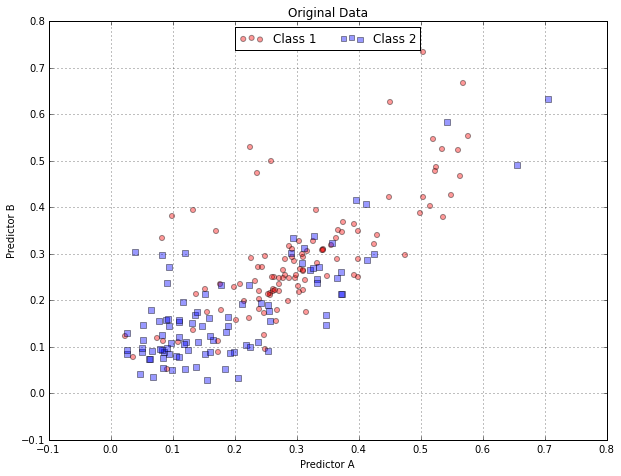

In [5]:
colors = ['r', 'b']
markers = ['o', 's']
c = ['Class1', 'Class2']
for k, m in enumerate(colors):
    i = np.where(classes.iloc[:,0] == c[k])[0]
    if k == 0:
        plt.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
    else:
        plt.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

plt.title('Original Data')
plt.xlabel('Predictor A')
plt.ylabel('Predictor B')
plt.legend(loc='upper center', ncol=2)
plt.show()

Notice that there is a significant overlap between the classes which is often the case for most applied modeling problems.

Compare two classification models using boundary lines.

In [6]:
## basic settings for classification boundary
X = np.array(predictors)
y = np.ravel(classes)

h = .002  # step size in the mesh
# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() -0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

In [7]:
## K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

## 3 neighbors (use odd value to avoid ties)
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, y)
Z3 = neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z3 = Z3.reshape(xx.shape)
Z3 = (Z3 == 'Class1').astype('int')

## optimal neighbors
knn_param = {
    'n_neighbors': range(1, 100),
}

gs_neigh = GridSearchCV(KNeighborsClassifier(), knn_param, cv = 2, n_jobs=-1)
gs_neigh.fit(X, y)
Z = gs_neigh.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
Z = (Z == 'Class1').astype('int')

<matplotlib.contour.QuadContourSet instance at 0x10e363638>

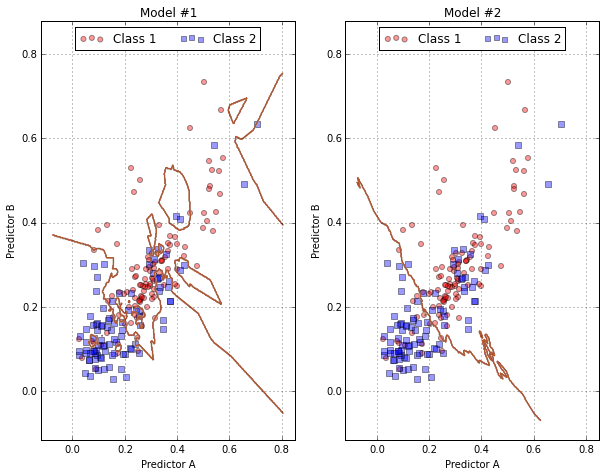

In [8]:
colors = ['r', 'b']
markers = ['o', 's']
c = ['Class1', 'Class2']

fig, (ax1, ax2) = plt.subplots(1, 2)

for k, m in enumerate(colors):
    i = np.where(classes.iloc[:,0] == c[k])[0]
    if k == 0:
        ax1.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
    else:
        ax1.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

ax1.set_title('Model #1')
ax1.set_xlabel('Predictor A')
ax1.set_ylabel('Predictor B')
ax1.legend(loc='upper center', ncol=2)
# plot boundary
ax1.contour(xx, yy, Z3, cmap=plt.cm.Paired)


for k, m in enumerate(colors):
    i = np.where(classes.iloc[:,0] == c[k])[0]
    if k == 0:
        ax2.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 1')
    else:
        ax2.scatter(predictors.iloc[i, 0], predictors.iloc[i, 1], 
                    c=m, marker=markers[k], alpha=0.4, s=26, label='Class 2')

ax2.set_title('Model #2')
ax2.set_xlabel('Predictor A')
ax2.set_ylabel('Predictor B')
ax2.legend(loc='upper center', ncol=2)
# plot boundary
ax2.contour(xx, yy, Z, cmap=plt.cm.Paired)

The left-hand panel (Model #1) shows a boundary that is complex and attempts to encircle every possible data point. The right-hand panel shows an alternative model fit where the boundary is fairly smooth and does not overextend itself to correctly classfiy every data point in the training set.

To gauge how well the model is classifying samples, one might use the training set. In doing so, the estimated error rate for the model in the left-hand panel would be overly optimistic. Estimating the utility of a model by re-predicting the training set is referred to *apparent performance* of the model (e.g., the apparent error rate). In two dimensions, it is not difficult to visualize that one model is over-fitting, but most modeling problems are in much higher dimensions. In this situations, it is very important to have a tool for characterizing how much a model is over-fitting the training set.

## 4.2 Model Tuning

Many models have important parameters which cannot be directly estimated from the data. This type of model parameter is referred to as a *tuning parameter* because there is no analytical formula available to calculate an appropriate value. Since many of these parameters control the complexity of the model, poor choices of the values can result in over-fitting.

There are different approaches to searching for the best parameters. A general approach that can be applied to almost any model is to define a set of candidate values, generate reliable estimators of model utility across the candidates values, then choose the optimal settings. Once a candidate set of parameter values has been selected, then we must obtain trustworthy estimates of model performance. The performance on the hold-out samples is then aggregated into a performance profile which is then used to determine the final tuning parameters. We then build a final model with all of the training data using the selected tuning parameters.

There are procedures that algorithmically determine appropriate values for tuning parameters and iterate until they arrive at parameter settings with optimal performance. These techniques tend to evaluate a large number of candidate models and can be superior to a defined set of tuning parameters when model performances can be efficiently calculated (for a review see Cohen et al. (2005)).

A more difficult problem is obtaining trustworthy estimates of model performance for these candidate models. The apparent error rate can produce extremely optimistic performance estimates. A better approach is to test the model on samples that were not used for training. Evaluating the model on a test set is the obvious choice, but, to generate reasonable precision of the performance values, the size of the test set may need to be large. An alternative approach to evaluating a model on a single test set is to *resample* the training set. This process uses several modified versions of the training set to build multiple models and then uses statistical methods to provide honest estimates of model performance.

## 4.3 Data Splitting

A few of the common steps in model building are：
- Pre-processing the predictor data
- Estimating model parameters
- Selecting predictors for the model
- Evaluating model performance
- Fine tuning class prediction rules (via ROC curves, etc.)

Given a fixed amount of data, the modeler must decide how to "spend" their data points to accommodate these activities.

One of the first decisions to make when modeling is to decide which samples will be used to evaluate performance. Ideally, the model should be evaluated on samples that were not used to build or fine-tune the model, so that they provide an unbiased sense of model effectiveness. 

When a large amount of data is at hand, a set of samples can be set aside to evaluate the final model. However, when the number of samples is not large, a strong case can be made that a test set should be avoided because every sample may be needed for model building. Additionally, the size of the test set may not have sufficient power or precision to make reasonable judgements. Resampling methods, such as cross-validation, can be used to produce appropriate estimates of model performance using the training set.

If a test set is deemed necessary, there are several methods for splitting the samples. Non-random approaches to splitting the data are sometimes appropriate. However, in most cases, there is the desire to make the training and test sets as homogeneous as possible. Random sampling methods can be used to create similar data sets.

The simplest way to split the data into a training and test set is to take a simple random sample. This does not control for any of the data attributes, such as the percentage of data in the classes. When one class has a disproportionately small frequency compared to the others, there is a chance that the distribution of the outcomes may be substantially different between the training and test sets

To account for the outcome when splitting the data, stratified random sampling applies random sampling within subgroups so that the outcome distributions will match.

Alternatively, the data can be split on the basis of the predictor values, e.g. *dissimilarity sampling*. Dissimilarity between two samples can be measured in a number of ways, e.g. distance. To use dissimilarity as a tool for data splitting, suppose the test set is initialized with a single sample. The dissimilarity between this initial sample and the unallocated samples can be calculated. THe unallocated sample that is most dissimilar would then be added to the test set. Then, the third point added to the test set would be chosen as having the maximum group dissimilarity (e.g., the average/minimum dissimilarities to that group) to the existing set. 

In [9]:
# dissimilarity sampling
def group_dissimilarity(A, S):
    '''measure average dissimilarity between A and a group of samples S'''
    A = np.array(A, ndmin=2)
    A_extend = np.repeat(A, S.shape[0], axis=0)
    return np.mean(np.sqrt(np.sum((A_extend - S)**2, axis=1)))
    
def dissimilarity_sampling(data, train_prop = 0.5):
    '''dissimilarity sampling of a dataset into training and test set'''
    data = np.array(data, ndmin=2)
    n_data = data.shape[0]
    n_train = np.int(n_data*train_prop)
    rd_int = np.random.randint(n_data, size=1)
    train = np.array(data[rd_int, :], ndmin=2) # initial point
    data = np.delete(data, rd_int, axis=0) # remove selected sample from data
    
    # sampling
    counter = 1
    while counter < n_train:
        counter += 1
        dist_array = np.zeros(n_data - counter + 1)
        for idx, i in enumerate(data):
            dist_array[idx] = group_dissimilarity(i, train)
        dx = np.argmax(dist_array) # find the most dissimilar
        train = np.vstack([train, data[dx]])
        data = np.delete(data, dx, axis=0)
        
    return (train, data)

pred_train, pred_test = dissimilarity_sampling(predictors)
print "Dimensions of training set is {0}; test set is {1}".format(pred_train.shape, pred_test.shape)

Dimensions of training set is (104, 2); test set is (104, 2)


## 4.4 Resampling Techniques

Generally, resampling techniques for estimating model performance operate similarly: a subset of samples are used to fit a model and the remaining samples are used to estimate the efficacy of the model. This process is repeated multiple times and the results are aggregated and summarized. The differences in techniques usually center around the method in which subsamples are chosen.

### k-Fold Cross-Validation

The samples are randomly partitioned into k sets of roughly equal size. A model is fit using the all samples except the first subset (the first fold). The held-out samples are predicted by this model and used to estimate performance measures. The first subset is returned to the training set and procedure repeats with the second subset held out, and so on. The k resampled estimates of performance are summarized (with mean and standard error) and used to understand the relationship between the tuning parameters and model utility. A slight variant of the model is to used stratified random sampling to select the k partitions to create balance with respect to the outcome. Another version, leave-one-out cross-validation (LOOCV), is the special case where k is the number of samples. 

The choice of k is usually 5 or 10, but there is no formal rule. As k gets larger, the differenec in size between the training set and the resampling subsets gets smaller. As this difference decreases, the *bias* of the technique becomes smaller.

Another important aspect of a resampling technique is the uncertainty (i.e., variance or noise). An unbiased method may be estimating the correct value but may pay a high price in uncertainty. This means that repeating the resampling procedure may produce a very different value (but done enough times, it will estimate the true value). k-flod cross-validation generally has high variance compared to other methods and, for this reason, might not be attractive. It should be said that for large training sets, the potential issues with variane and bias becomes negligible.

### Generalized Cross-Validation

For linear regression models, there is a formula for approximating the leave-one-out error rate. The formula for the generalized corss-validation (GCV) statistic is the i-th training set outcome $$\text{GCV} = {1\over n} \sum_{i=1}^n \left({y_i - \hat{y}_i \over 1 - df/n} \right)^2,$$where $y_i$ is the i-th in the training set outcome, $\hat{y}_i$ is the model prediction of that outcome, and $df$ is the degrees of freedom of the model. The degrees of freedom are an accounting of how many parameters are estimated by the model and, by extension, a measure of complexity for linear regression models. Based on this equation, two models with the same sums of square errors (the numerator) would have different GCV values if the complexities of the models were different.

### Repeated Training/Test Splits

Repeated training/test splits is also known as "leave-group-out cross-validation" or "Monte Carlo cross-validation". This technique simple creates multiple splits of the data into modeling and prediction sets. One difference between this procedure and k-fold cross-validation is that samples can be represented in multiple held-out subsets. Also, the number of repetitions is usually larger than in k-fold cross-validation.

The proportion of the data going into each subset is controlled by the practitioner as is the number of repetitions. The bias of the resampling technique decreases as the amount of data in the subset approaches the amount in the modeling set. A good rule of thumb is about 75-80%. Higher proportions are a good idea if the number of repetitions is large.

The number of repetitions is important. Increasing the number of subsets has the effect of decreasing the uncertainty of the performance estimates. To get stable estimates of performance, it is suggested to choose a larger number of repetitions (say 50-200). This is also a function of the proportion of samples being randomly allocated to the prediction set; the larger the percentage, the more repetitions are needed to reduce the uncertainty in the performance estimates.

### The Bootstrap

A bootstrap sample is a random sample of the data taken *with replacement*. The bootstrap sample size is the same size as the original data set. As a result, some samples will be represented multiple times in the bootstrap sample while others will not be selected at all. The samples not selected are usually referred to as the "out-of-bag" samples. For a given bootstrap resampling, a model is built on the selected samples and is used to predict the out-of-bag samples.

In general, bootstrap error rates tend to have less uncertainty than k-fold cross-validation. However, on average, 63.2% of the data points the bootstrap sample are represented at least once, so this technique has bias similar to k-fold cross-validation when $k \approx 2$.

A few modifications of the simple bootstrap procedure have been devised to eliminate this bias, such as the "632 method" and the "632+ method". If a classification model was characterized by its error rate, the 632 method would use $$(0.632 \times \text{simple bootstrap estimate}) + (0.369 \times \text{apparent error rate}).$$ The modified bootstrap estimate reduces the bias, but can be unstable with small sample sizes.

#### Side note

Why each bootstrap sample contains roughly 63.2% of the observations?

We populate $S = \{ s_1, \cdots, s_n \}$ by sampling $\text{Obs} = \{ d_1, \cdots, d_n \}$ for n times with replacement. Consider a particular observation $d_m$. Then the probability that this particular observation in bootstrap sample is $$P(d_m \in S) = 1 - P(d_m \notin S) = 1 - \prod_{i=1}^n P(s_i \neq d_m ) = 1 - \prod_{i=1}^n (1-{1\over n}) \to 1 - e^{-1} \approx 0.638. $$

## 4.5 Case Study: Credit Scoring

The German credit data set is a popular tool for benchmarking machine learning algorithms。

In [10]:
# check if exists
!ls -l ../datasets/GermanCredit/

total 480
-rw-r--r--  1 leigong  staff  244776 Nov 18 16:08 GermanCredit.csv


In [11]:
germancredit = pd.read_csv("../datasets/GermanCredit/GermanCredit.csv")
germancredit.head(5)

Unnamed: 0  Duration  Amount  InstallmentRatePercentage  ResidenceDuration  \
0           1         6    1169                          4                  4   
1           2        48    5951                          2                  2   
2           3        12    2096                          2                  3   
3           4        42    7882                          2                  4   
4           5        24    4870                          3                  4   

   Age  NumberExistingCredits  NumberPeopleMaintenance  Telephone  \
0   67                      2                        1          0   
1   22                      1                        1          1   
2   49                      1                        2          1   
3   45                      1                        2          1   
4   53                      2                        2          1   

   ForeignWorker      ...       OtherInstallmentPlans.Bank  \
0              1      ...                                0   
1              1      ...                                0   
2              1      ...                                0   
3              1      ...                                0   
4              1      ...                                0   

   OtherInstallmentPlans.Stores  OtherInstallmentPlans.None  Housing.Rent  \
0                             0                           1             0   
1                             0                           1             0   
2                             0                           1             0   
3                             0                           1             0   
4                             0                           1             0   

   Housing.Own  Housing.ForFree  Job.UnemployedUnskilled  \
0            1                0                        0   
1            1                0                        0   
2            1                0                        0   
3            0                1                        0   
4            0                1                        0   

   Job.UnskilledResident  Job.SkilledEmployee  \
0                      0                    1   
1                      0                    1   
2                      1                    0   
3                      0                    1   
4                      0                    1   

   Job.Management.SelfEmp.HighlyQualified  
0                                       0  
1                                       0  
2                                       0  
3                                       0  
4                                       0  

[5 rows x 63 columns]

In [12]:
germancredit = germancredit.drop('Unnamed: 0', axis=1) # drop the first column
germancredit.shape

(1000, 62)

In [13]:
germancredit.groupby('Class').count()

Duration  Amount  InstallmentRatePercentage  ResidenceDuration  Age  \
Class                                                                        
Bad         300     300                        300                300  300   
Good        700     700                        700                700  700   

       NumberExistingCredits  NumberPeopleMaintenance  Telephone  \
Class                                                              
Bad                      300                      300        300   
Good                     700                      700        700   

       ForeignWorker  CheckingAccountStatus.lt.0             ...              \
Class                                                        ...               
Bad              300                         300             ...               
Good             700                         700             ...               

       OtherInstallmentPlans.Bank  OtherInstallmentPlans.Stores  \
Class                                                             
Bad                           300                           300   
Good                          700                           700   

       OtherInstallmentPlans.None  Housing.Rent  Housing.Own  Housing.ForFree  \
Class                                                                           
Bad                           300           300          300              300   
Good                          700           700          700              700   

       Job.UnemployedUnskilled  Job.UnskilledResident  Job.SkilledEmployee  \
Class                                                                        
Bad                        300                    300                  300   
Good                       700                    700                  700   

       Job.Management.SelfEmp.HighlyQualified  
Class                                          
Bad                                       300  
Good                                      700  

[2 rows x 61 columns]

To demonstrate the process of tuning models using resampling, we took a stratified random sample of 800 customers to use for training models. The remaining samples will be used as a test set to verify performance when a final model is determined.

In [14]:
def stratified_sampling(data, target, prop_train):
    '''a stratified random sampling based on proportion of the target outcomes.'''
    from collections import Counter
    
    n_class = dict(Counter(data[target]).items()) # frequency of possible outcomes
    data.reindex(np.random.permutation(data.index)) # random shuffle
    for key, val in n_class.iteritems():
        n_train = np.int(val*prop_train)
        try:
            trainset = trainset.append(data[data[target] == key].iloc[:n_train,:], ignore_index=True)
            testset = testset.append(data[data[target] == key].iloc[n_train:, :], ignore_index=True)
        except NameError:
            trainset = data[data[target] == key].iloc[:n_train,:]
            testset = data[data[target] == key].iloc[n_train:, :]
        
    return trainset, testset
    
credit_train, credit_test = stratified_sampling(germancredit, 'Class', 0.8)
print "The size of training set is {0} and test set is {1}.".format(credit_train.shape[0], credit_test.shape[0])

The size of training set is 800 and test set is 200.


## 4.6 Choosing Final Tuning Parameters

Once final model performance has been quantified across sets of tuning parameters, there are several philosophies on how to choose the final settings. The simplest approach is to pick the settings associated with the numerically best performance estimates.

In [15]:
X_train = credit_train.drop('Class', axis=1)
y_train = credit_train['Class']
X_test = credit_test.drop('Class', axis=1)
y_test = credit_test['Class']

In [16]:
# Support Vector Machine with kernel 'rbf'
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV

svc_param = {
    'C': np.logspace(-2, 7,num=10, base = 2),
}

In [17]:
# 10-fold CV for each model
from scipy.stats import sem

gs_svm = GridSearchCV(SVC(kernel = 'rbf'), svc_param, cv=10, n_jobs=-1)
%time _ = gs_svm.fit(X_train, y_train)

#cross-validated score
cv_score = np.zeros([len(svc_param['C']), 2])
for idx, i in enumerate(gs_svm.grid_scores_):
    cv_score[idx, 0] = np.mean(i[2])
    cv_score[idx, 1] = sem(i[2]) * 2 # two standard errors
    
gs_svm.grid_scores_

CPU times: user 483 ms, sys: 57.3 ms, total: 541 ms
Wall time: 3.56 s


[mean: 0.70000, std: 0.00000, params: {'C': 0.25},
 mean: 0.70000, std: 0.00000, params: {'C': 0.5},
 mean: 0.69000, std: 0.01346, params: {'C': 1.0},
 mean: 0.67000, std: 0.03172, params: {'C': 2.0},
 mean: 0.66875, std: 0.03075, params: {'C': 4.0},
 mean: 0.66750, std: 0.03172, params: {'C': 8.0},
 mean: 0.66750, std: 0.03172, params: {'C': 16.0},
 mean: 0.66750, std: 0.03172, params: {'C': 32.0},
 mean: 0.66750, std: 0.03172, params: {'C': 64.0},
 mean: 0.66750, std: 0.03172, params: {'C': 128.0}]

In [18]:
# apparent score
apparent_score = np.zeros(len(svc_param['C']))

# iterate over all models
for cdx, c in enumerate(svc_param['C']):
    svm = SVC(kernel = 'rbf', C = c)
    svm.fit(X_train, y_train)
    apparent_score[cdx] = svm.score(X_train, y_train)

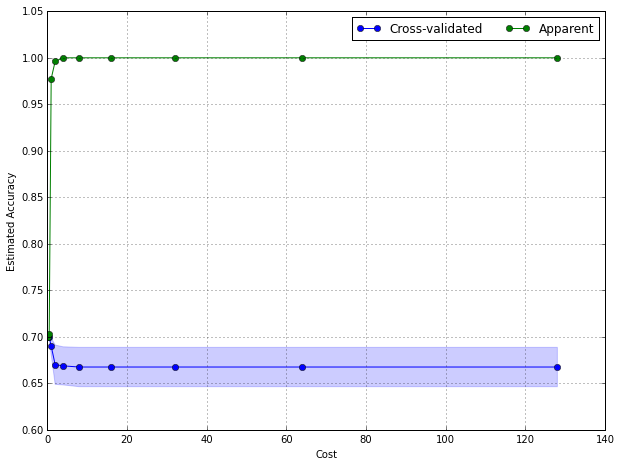

In [19]:
plt.fill_between(svc_param['C'],
                 cv_score[:,0] - cv_score[:,1],
                 cv_score[:,0] + cv_score[:,1],
                 color = 'b', alpha = .2)
plt.plot(svc_param['C'], cv_score[:,0], 'o-k', c='b', label='Cross-validated')

plt.plot(svc_param['C'], apparent_score, 'o-k', c='g', label='Apparent')

plt.xlabel('Cost')
plt.ylabel('Estimated Accuracy')
plt.ylim((None, 1.05))
plt.legend(loc = 'upper right', ncol=2)

Note that the over-estimation of the accuracy from the apparent score is likely due to over-fitting.

In general, it may be a good idea to favor simpler models over more complex ones and choosing the tuning parameters based on the numerically optimal value may lead to models that are overly complicated. Other schemes for choosing less complex models should be investigated as they might lead to simpler models that provide acceptable performance.

The "one-standard-error" method for choosing simpler models find the numerically optimal value and its corresponding standard error and then seeks the simplest model whose performance is within a single standard error of the numerically best value.

Another approach is to choose a simpler model that is within a certain tolerance of the numerically best value. The percent decreases in performance could be quantified by $(X - O)/O$ where $X$ is the performance value and $O$ is the numerically optimal value.

Additional resampling techniques were applied to the same data: 10-fold cross-validation, LOOCV, the bootstrap (with and without the 632 adjustment), and repeated training/test splits (with 20% held-out). THe latter two methods used 50 resamples to estimate performance.

In [20]:
# LOOCV (leave-one-out cross-validation)
from sklearn.cross_validation import LeaveOneOut

gs_svm = GridSearchCV(SVC(kernel = 'rbf'), svc_param, cv=LeaveOneOut(X_train.shape[0]), n_jobs=-1)
%time _ = gs_svm.fit(X_train, y_train)

#cross-validated score
loocv_score = np.zeros([len(svc_param['C']), 2])
for idx, i in enumerate(gs_svm.grid_scores_):
    loocv_score[idx, 0] = np.mean(i[2])
    loocv_score[idx, 1] = sem(i[2])*2 # two standard errors

CPU times: user 31.2 s, sys: 3.36 s, total: 34.6 s
Wall time: 6min


Note that the LOOCV takes siginificantly longer time to run when compared to other methods. It should be considered only when the number of samples is very small.

In [21]:
# bootstrap (with/without 632 method)
bootstrap_score = np.zeros([len(svc_param['C']), 2])
bootstrap632_score = np.zeros([len(svc_param['C']), 2])

n_resamples = 50

def bootstrap_resample(X, y):
    '''generate bootstrap training/test set.'''
    sample_size = X.shape[0]
    boot_idx = np.random.choice(sample_size, sample_size)
    # find out-of-bag samples
    boot_outbag = list(set(range(sample_size)) - set(np.unique(boot_idx)))
    X_bs, X_outbag = X.iloc[boot_idx, :], X.iloc[boot_outbag, :]
    y_bs, y_outbag = y[boot_idx], y[boot_outbag]
    return X_bs, X_outbag, y_bs, y_outbag

# iterate over all models
for cdx, c in enumerate(svc_param['C']):
    scores = np.zeros(n_resamples)
    scores_632 = np.zeros(n_resamples)
    for r in range(n_resamples):
        X_bs, X_outbag, y_bs, y_outbag = bootstrap_resample(X_train, y_train)
        svm = SVC(kernel = 'rbf', C = c)
        svm.fit(X_bs, y_bs)
        scores[r] = svm.score(X_outbag, y_outbag)
        # 632 method
        scores_632[r] = 0.632*svm.score(X_outbag, y_outbag) + 0.368*svm.score(X_bs, y_bs)
    bootstrap_score[cdx, 0] = np.mean(scores)
    bootstrap_score[cdx, 1] = sem(scores)*2 # two standard errors
    bootstrap632_score[cdx, 0] = np.mean(scores_632)
    bootstrap632_score[cdx, 1] = sem(scores_632)*2 # two standard errors

In [22]:
# repeated training/test splits
repeated_score = np.zeros([len(svc_param['C']), 2])

n_resamples = 50
p_heldout = 0.2 # proportion of held-out

def random_splits(X, y, p_heldout):
    '''random split training/test set.'''
    sample_idx = range(X.shape[0])
    n_heldout = np.int(X.shape[0]*p_heldout)
    np.random.shuffle(sample_idx)
    heldout_idx = sample_idx[:n_heldout]
    sample_idx = sample_idx[n_heldout:]
    X_heldout, X_sample = X.iloc[heldout_idx, :], X.iloc[sample_idx, :]
    y_heldout, y_sample = y[heldout_idx], y[sample_idx]
    return X_sample, X_heldout, y_sample, y_heldout

# iterate over all models
for cdx, c in enumerate(svc_param['C']):
    scores = np.zeros(n_resamples)
    for r in range(n_resamples):
        X_sample, X_heldout, y_sample, y_heldout = random_splits(X_train, y_train, p_heldout)
        svm = SVC(kernel = 'rbf', C = c)
        svm.fit(X_sample, y_sample)
        scores[r] = svm.score(X_heldout, y_heldout)
    repeated_score[cdx, 0] = np.mean(scores)
    repeated_score[cdx, 1] = sem(scores)*2 # two standard erros
    
print repeated_score

[[ 0.69325     0.00755794]
 [ 0.70975     0.00877118]
 [ 0.6885      0.00913588]
 [ 0.670625    0.00936266]
 [ 0.676       0.00886664]
 [ 0.6685      0.00854878]
 [ 0.672125    0.00852076]
 [ 0.6715      0.01197979]
 [ 0.666375    0.00920909]
 [ 0.672125    0.00966406]]


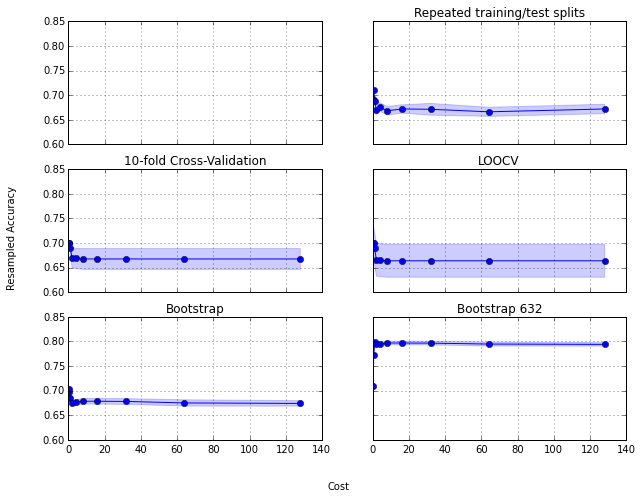

In [23]:
fig, axarr = plt.subplots(3, 2, sharex=True, sharey=True)

# apparent score
#axarr[0, 0].plot(svc_param['C'], apparent_score, 'o-k', c='b')
#axarr[0, 0].set_title("Apparent")
#axarr[0, 0].set_ylim((None, 1.05))

# 10-fold cross-validation
axarr[1, 0].fill_between(svc_param['C'],
                 cv_score[:,0] - cv_score[:,1],
                 cv_score[:,0] + cv_score[:,1],
                 color = 'b', alpha = .2)
axarr[1, 0].plot(svc_param['C'], cv_score[:,0], 'o-k', c='b')
axarr[1, 0].set_title('10-fold Cross-Validation')

# LOOCV
axarr[1, 1].fill_between(svc_param['C'],
                 loocv_score[:,0] - loocv_score[:,1],
                 loocv_score[:,0] + loocv_score[:,1],
                 color = 'b', alpha = .2)
axarr[1, 1].plot(svc_param['C'], loocv_score[:,0], 'o-k', c='b')
axarr[1, 1].set_title('LOOCV')

# Bootstrap
axarr[2, 0].fill_between(svc_param['C'],
                 bootstrap_score[:,0] - bootstrap_score[:,1],
                 bootstrap_score[:,0] + bootstrap_score[:,1],
                 color = 'b', alpha = .2)
axarr[2, 0].plot(svc_param['C'], bootstrap_score[:,0], 'o-k', c='b')
axarr[2, 0].set_title('Bootstrap')

# Bootstrap with 632
axarr[2, 1].fill_between(svc_param['C'],
                 bootstrap632_score[:,0] - bootstrap632_score[:,1],
                 bootstrap632_score[:,0] + bootstrap632_score[:,1],
                 color = 'b', alpha = .2)
axarr[2, 1].plot(svc_param['C'], bootstrap632_score[:,0], 'o-k', c='b')
axarr[2, 1].set_title('Bootstrap 632')

#
axarr[0, 1].fill_between(svc_param['C'],
                 repeated_score[:,0] - repeated_score[:,1],
                 repeated_score[:,0] + repeated_score[:,1],
                 color = 'b', alpha = .2)
axarr[0, 1].plot(svc_param['C'], repeated_score[:,0], 'o-k', c='b', label='Repeated training/test splits')
axarr[0, 1].set_title('Repeated training/test splits')

fig.text(0.5, 0.04, 'Cost', ha='center', va='center')
fig.text(0.04, 0.5, 'Resampled Accuracy', va='center', rotation='vertical')
#fig.xlabel('Cost')
#fig.ylabel('Estimated Accuracy')
#fig.ylim('Estimated Accuracy')
#fig.legend(loc = 'upper right', ncol=2)

Note that the standard error bands for LOOCV are wider than other techniques, mostly because it predicts only one sample at a time which subjects to large fluctuation. The reason why 10-fold Cross-Validation has a wider error bands when compared to the rest techniques is because of its small resample size (10 versus 50 used by the bootstrap and repeated splits). The 632 rule appears to overcompensate for the bias and estimate the accurarcy to be higher than others.

## 4.7 Data Splitting Recommendations

There is a strong technical case to be made against a single, independent test set:
- A test set is a single evaluation of the model and has limited ability to characterize the uncertainty in the results.
- Proportionally large test sets divide the data in a way that increases bias in the performance estimates.
- With small sample sizes:
    - The model may need every possible data point to adequately determine model values.
    - The uncertainty of the test set can be considerably large to the point where different test sets may produce very different results.
- Resampling methods can produce reasonable predictions of how well the model will perform on future samples.

No resampling method is uniformly better than another. If the sample size is small, we recommend repeated 10-fold cross-validation: the bias and variance properties are good and, given the sample size, the computational costs are not large. If the goal is to choose between models, as opposed to getting the best indicator of performance, a strong case can be made for using one of the bootstrap procedures since these have very low variance. For large sample size, the difference between resampling methods become less pronounced, and computational efficiency increases in importance.

## 4.8 Choosing Between Models

Once the settings for the tuning parameters have been determined for each model, we suggest the following scheme for finalizing the type of model:
1. Start with several models that are the least interpretable and most flexible, such as boosted trees or support vector machines. Across many problem domains, these models have a high likelihood of producing the empirically optimum results.
2. Investigate simpler models that are less opaque (e.g., not complete black box), such as multivariate adaptive regression splines (MARS), partial least squares, generalized additive models, or naive Bayes models.
3. Consider using the simplest model that reasonably approximates the performance of the more complex methods.

Using this methodology, the modeler can discover the "performance ceiling" for the data set before settling on a model. In many cases, a range of models will be equivalent in terms of performance so the practitioner can weight the benefits of different methodologies (e.g., computational complexity, easy of prediction, interpretability).